In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("../")

# CRF model

We consider the input image $I$ to be a graph $V$ with each node $v$ carrying pixel data (RGB). Then we can see about downsampling using e.g. SLIC.

We want to classify each node $v$ as foreground ($1$) or background ($-1$). For this, we will use a conditional random field (CRF) model specified over the nodes: the label likelihood factors as logistic regression given a latent variable $Z_v$ at node $v$:
$$
    p(l_v|Z_v;\theta) = g(l_v\theta^\intercal Z_v)\quad
    \text{where}\ g(u) = \frac{e^u}{e^u + 1}
$$
and $\theta$ is a parameter vector we learn over the set of examples.

The data likelihood is given by
$$
    \mathcal L(\theta; I) = \log\left(
        \sum_Z p(l|Z;\theta) p(Z|I)
    \right) =
    \log\left(\sum_Z
    \left[ \prod_{v\in V} 
            g(l_v\theta^\intercal Z_v)\right] p(Z|I)
    \right)
$$

In [2]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

import glob

IMAGE_FOLDER = "data/train/images"
MASKS_FOLDER = "data/train/masks"

IMAGES = sorted(glob.glob(os.path.join(IMAGE_FOLDER, "*.jpg")))
MASKS = sorted(glob.glob(os.path.join(MASKS_FOLDER, "*.png")))

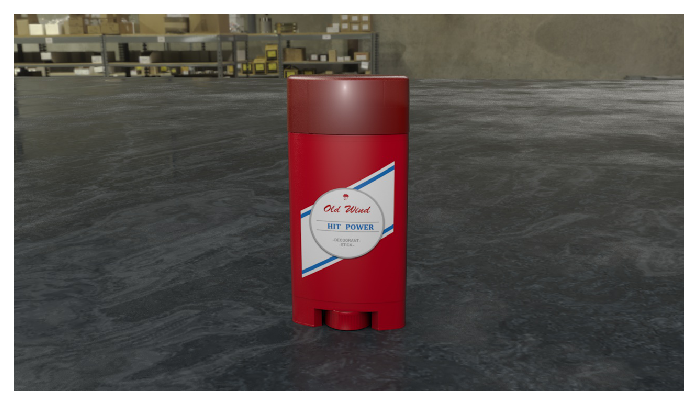

In [7]:
## Load an image
img = cv2.imread(IMAGES[2])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mask = cv2.imread(MASKS[2])

plt.imshow(img)
plt.axis('off');

## Smart downsampling with SLIC

We define a SLIC superpixel model with $N=400$ components.

In [8]:
from fast_slic.avx2 import SlicAvx2

In [9]:
slic = SlicAvx2(num_components=1000, compactness=10)

In [10]:
assignments = slic.iterate(img)

In [11]:
from skimage import color
from skimage.segmentation import mark_boundaries

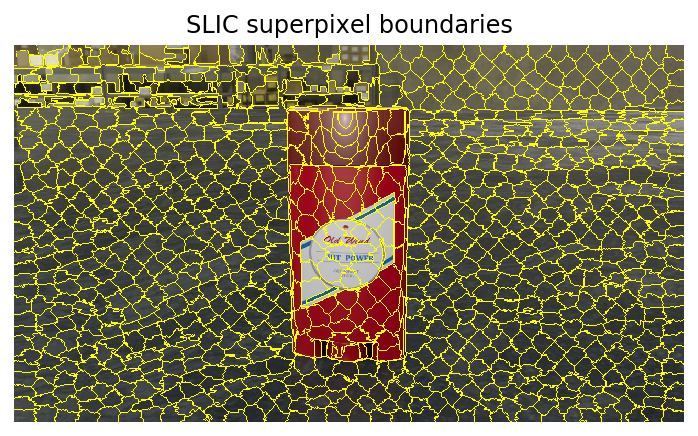

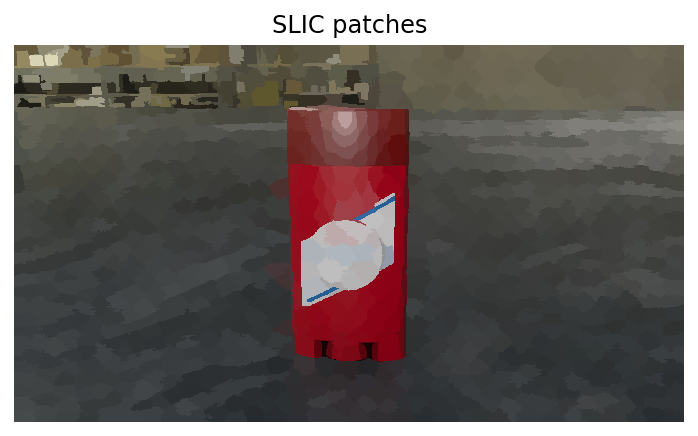

In [12]:
img_slic_boundaries = mark_boundaries(img, assignments)
img_slic = color.label2rgb(assignments, img, kind='avg')

plt.figure()
plt.title("SLIC superpixel boundaries")
plt.imshow(img_slic_boundaries)
plt.axis('off')

plt.figure()
plt.title("SLIC patches")
plt.imshow(img_slic)
plt.axis('off');

Now, we want to infer the labels of the SLIC cluster graph nodes.

In [13]:
## Recover the neighbors of each node
from utils import get_slic_graph

In [14]:
nodes, neighbors = get_slic_graph(slic, assignments)

In [15]:
print("NODE0:", nodes[0])
print("Neighbors:")
for n in neighbors[0]:
    print(nodes[n])

NODE0: {'number': 0, 'yx': (11.0, 21.0), 'color': (75.0, 129.0, 163.0), 'num_members': 271}
Neighbors:
{'number': 1, 'yx': (12.0, 64.0), 'color': (112.0, 121.0, 156.0), 'num_members': 303}
{'number': 41, 'yx': (18.0, 340.0), 'color': (91.0, 126.0, 172.0), 'num_members': 278}


In [16]:
def get_node_mask(mask, nodes):
    out = np.empty((len(nodes),), dtype=int)
    for i, n in enumerate(nodes):
        y, x = n['yx']
        y = int(y); x = int(x)
        out[i] = mask[y,x, 0] > 0
    return out

In [17]:
mask_nodes = get_node_mask(mask, nodes)

## Conditionally deterministic $Z$

Let's define the latent variable $Z$ to be a deterministic feature function of the node data $X$.

In this case, the likelihood function collapses to
$$
    \mathcal L(\theta; X) = \log\left(
        p(l|Z;\theta) p(Z|X)
    \right) =
    \sum_{v\in V} 
    \log g(\theta^\intercal Z_v)
    + \log p(Z|X)
$$

An easy choice to recover image data is to say that for all nodes $v$, $Z_v$ is the graph Laplacian at $v$.

In [18]:
def get_laplacian_node(nodes, neighbors, i: int):
    node = nodes[i]
    neigh = neighbors[i]
    col = np.asarray(node['color'])
    if len(neigh) > 0:
        lap = 1./len(neigh) * np.sum([
            np.asarray(nodes[j]['color']) - col
            for j in neigh], axis=0)
    else:
        lap = np.zeros((3,))
    return lap

def get_laplacian(node, neighbors):
    """Get full Laplacian features for each color channel."""
    return np.array([
        get_laplacian_node(nodes, neighbors, i)
        for i in range(len(nodes))
    ])

In [19]:
Z = get_laplacian(nodes, neighbors)

In [20]:
from scipy.special import expit

In [21]:
from scipy.optimize import minimize

In [28]:
def compute_mle(labels):
    EPSILON = 1e-16
    def objective(theta):
        return -np.sum(np.log(expit(labels * Z @ theta) + EPSILON))

    def gradient(theta):
        weights = expit(-labels * Z @ theta)[:, None]
        return -np.sum(labels * weights * Z, axis=0)
    
    prog = minimize(objective, np.random.rand(3), jac=gradient)
    return prog

In [29]:
labels = mask_nodes[:, None] * 2 - 1

In [30]:
res = compute_mle(labels)

In [31]:
res

      fun: 433.6581196880681
 hess_inv: array([[ 2.81003398e-05,  2.45356274e-05, -9.91092237e-06],
       [ 2.45356274e-05,  3.71412698e-04, -1.00289573e-04],
       [-9.91092237e-06, -1.00289573e-04,  1.53985035e-04]])
      jac: array([3.49701887e-07, 2.78239552e-07, 8.18937480e-08])
  message: 'Optimization terminated successfully.'
     nfev: 25
      nit: 18
     njev: 25
   status: 0
  success: True
        x: array([-0.03057273, -0.21597854,  0.05535906])

In [32]:
def predict(theta):
    """Predict node label=1 probability."""
    return expit(Z @ theta)

In [33]:
prob_predict = predict(theta=res.x)

In [34]:
labels_predict = (prob_predict > .5).astype(int) * 2 - 1

In [35]:
from sklearn.metrics import accuracy_score
from utils.metrics import dice_score

In [36]:
accuracy_score(labels, labels_predict)

0.746

In [65]:
def rebuild_mask(img, assignments, labels_predict):
    """Build a mask from the predicted labels and assignment matrix."""
    mask = np.zeros_like(img)
    mask[labels_predict[assignments] > 0] = 255
    return mask

In [66]:
mask_predict = rebuild_mask(img, assignments, labels_predict)

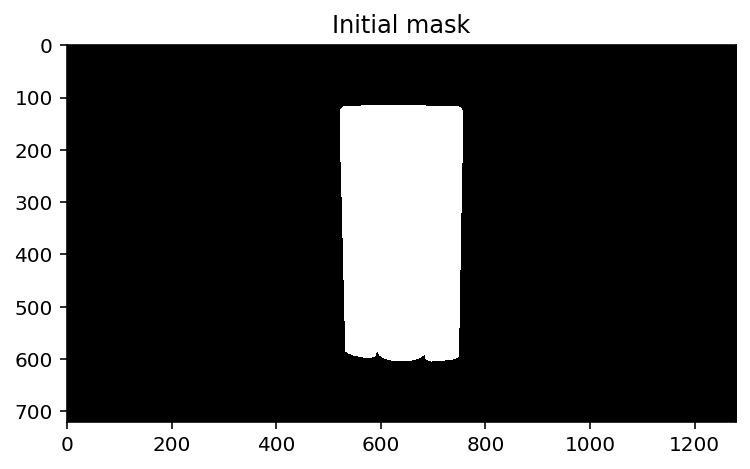

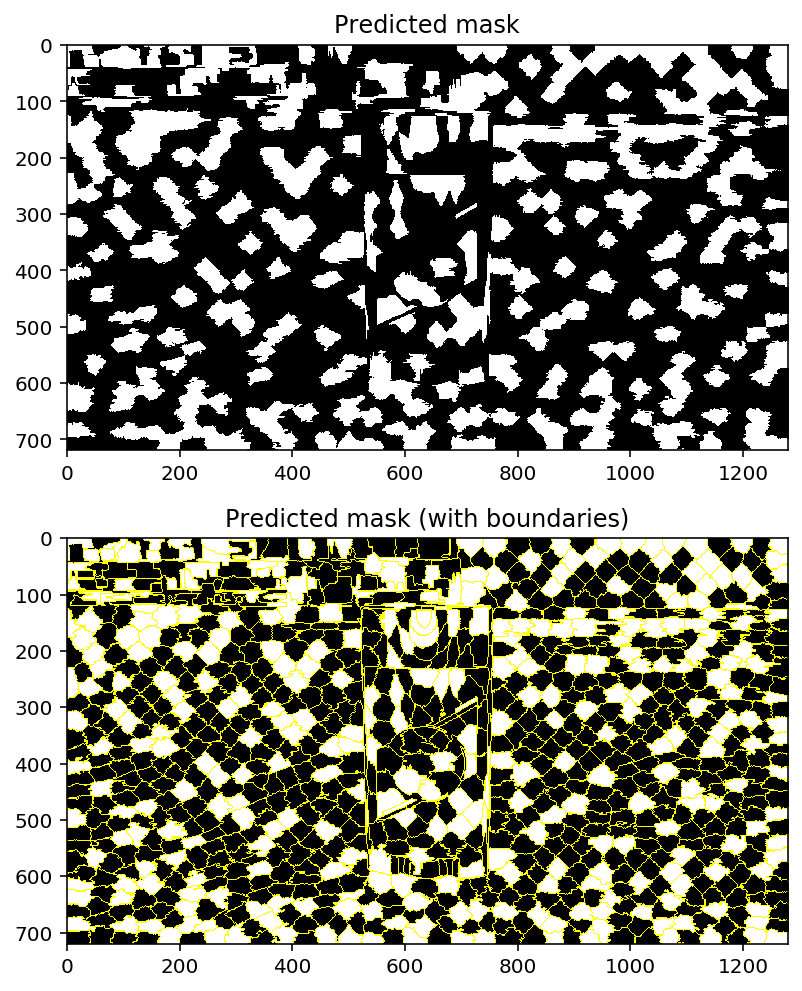

In [64]:
plt.figure()
plt.title("Initial mask")
plt.imshow(mask)


plt.figure(figsize=(9, 7))
mask_predict_boundaries = mark_boundaries(mask_predict, assignments)
plt.subplot(211)
plt.title("Predicted mask")
plt.imshow(mask_predict)
plt.subplot(212)
plt.title("Predicted mask (with boundaries)")
plt.imshow(mask_predict_boundaries)
plt.tight_layout();

## Stochastic latent $Z$

### EM algorithm